In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
import tarfile
from six.moves import urllib

In [2]:
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

In [3]:
def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [4]:
import pandas as pd

In [5]:
def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [6]:
fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH)
housing = load_housing_data(housing_path=HOUSING_PATH)

In [7]:
housing.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [10]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [11]:
from sklearn.model_selection import StratifiedShuffleSplit

In [12]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [13]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

In [14]:
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [15]:
compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

In [16]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

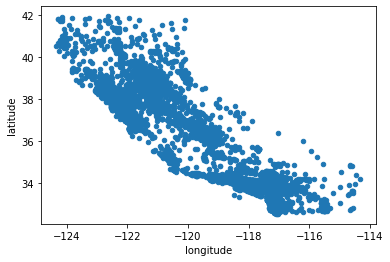

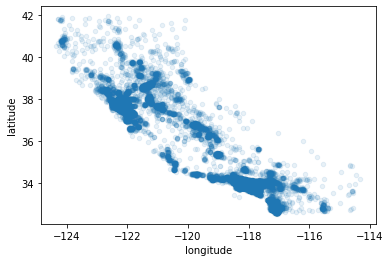

In [17]:
housing = strat_train_set.copy()
housing.plot(kind="scatter", x="longitude", y="latitude")
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

In [18]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [19]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

In [20]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [21]:
housing_num = housing.drop('ocean_proximity', axis=1)

In [22]:
imputer.fit(housing_num)
X = imputer.transform(housing_num)

In [23]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns,
                          index=housing.index)
housing_tr["rooms_per_household"] = housing_tr["total_rooms"]/housing_tr["households"]
housing_tr["bedrooms_per_room"] = housing_tr["total_bedrooms"]/housing_tr["total_rooms"]
housing_tr["population_per_household"]=housing_tr["population"]/housing_tr["households"]

In [24]:
housing_cat = housing[['ocean_proximity']]
housing_prepared = housing_tr.join(pd.get_dummies(housing_cat, drop_first=True))

In [25]:
from sklearn.linear_model import LinearRegression

In [26]:
lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [27]:
from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848922

In [28]:
from sklearn.metrics import mean_absolute_error
lin_mae = mean_absolute_error(housing_labels, housing_predictions)
lin_mae

49439.89599001878

In [29]:
from sklearn.tree import DecisionTreeRegressor

In [30]:
tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [31]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

In [33]:
param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

In [34]:
forest_reg = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(housing_prepared, housing_labels)
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

49155.170365634505 {'max_features': 7, 'n_estimators': 180}
50987.04312458704 {'max_features': 5, 'n_estimators': 15}
50615.062741858346 {'max_features': 3, 'n_estimators': 72}
50384.45258861629 {'max_features': 5, 'n_estimators': 21}
49311.12724384495 {'max_features': 7, 'n_estimators': 122}
50620.02725664336 {'max_features': 3, 'n_estimators': 75}
50544.81214288387 {'max_features': 3, 'n_estimators': 88}
49425.39483845691 {'max_features': 5, 'n_estimators': 100}
50424.43333681439 {'max_features': 3, 'n_estimators': 150}
64513.81455303026 {'max_features': 5, 'n_estimators': 2}


In [35]:
from sklearn.model_selection import GridSearchCV

In [36]:
param_grid = [
    # try 12 (3Ã—4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2Ã—3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

In [37]:
forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [38]:
grid_search.best_params_
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

64756.15287120735 {'max_features': 2, 'n_estimators': 3}
56063.4893319337 {'max_features': 2, 'n_estimators': 10}
53273.90806143431 {'max_features': 2, 'n_estimators': 30}
59101.28067228025 {'max_features': 4, 'n_estimators': 3}
52474.6964949602 {'max_features': 4, 'n_estimators': 10}
50255.25226845538 {'max_features': 4, 'n_estimators': 30}
58478.93093971638 {'max_features': 6, 'n_estimators': 3}
51882.75302588659 {'max_features': 6, 'n_estimators': 10}
49868.92531447902 {'max_features': 6, 'n_estimators': 30}
57806.27616477774 {'max_features': 8, 'n_estimators': 3}
51835.9458092803 {'max_features': 8, 'n_estimators': 10}
50203.329994664484 {'max_features': 8, 'n_estimators': 30}
64112.198842075566 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
54651.51712479169 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
61288.864185527455 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
53224.19707673298 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10

In [39]:
feature_importances = grid_search.best_estimator_.feature_importances_
sorted(zip(feature_importances, housing_prepared.columns), reverse=True)

[(0.3451103236913101, 'median_income'),
 (0.1478412844883504, 'ocean_proximity_INLAND'),
 (0.11218326908225117, 'population_per_household'),
 (0.07783681697706872, 'longitude'),
 (0.0751746606892534, 'bedrooms_per_room'),
 (0.07179004008993167, 'latitude'),
 (0.05391086257496505, 'rooms_per_household'),
 (0.04242440016669158, 'housing_median_age'),
 (0.017789710715344784, 'total_rooms'),
 (0.01726300298017504, 'population'),
 (0.01604878496021236, 'total_bedrooms'),
 (0.01596868573039805, 'households'),
 (0.003998579606979546, 'ocean_proximity_NEAR OCEAN'),
 (0.0026028177981955174, 'ocean_proximity_NEAR BAY'),
 (5.6760448872649945e-05, 'ocean_proximity_ISLAND')]

In [40]:
final_model = grid_search.best_estimator_

In [41]:
X_test = strat_test_set.drop("median_house_value", axis=1)
y_test = strat_test_set["median_house_value"].copy()

In [42]:
X_test_num = X_test.drop('ocean_proximity', axis=1)
X_test_prepared = imputer.transform(X_test_num)
X_test_prepared = pd.DataFrame(X_test_prepared, columns=X_test_num.columns,
                          index=X_test.index)
X_test_prepared["rooms_per_household"] = X_test_prepared["total_rooms"]/X_test_prepared["households"]
X_test_prepared["bedrooms_per_room"] = X_test_prepared["total_bedrooms"]/X_test_prepared["total_rooms"]
X_test_prepared["population_per_household"]=X_test_prepared["population"]/X_test_prepared["households"]

In [43]:
X_test_cat = X_test[['ocean_proximity']]
X_test_prepared = X_test_prepared.join(pd.get_dummies(X_test_cat, drop_first=True))

In [44]:
final_predictions = final_model.predict(X_test_prepared)
final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)